# Introduction



---



---



In this notebook, we will implement the following tests for the LINEAR KOPTEVA PROBLEM:


a) For each epsilon:

i) Gauss Siedall MP-Iteration. Compute Hessian M based on the current physical solution and mesh, take $\alpha_{hat} = \epsilon^{-3/4}$ (for $m=0$) or $\alpha_{hat} = \epsilon^{-5/4}$ (for $m=1$)

ii) Continuation in $u$ and $x$

b) Compare errors, solutions, etc


# Results and Comments


---



---


Some of the best results we have seen! These results indicated a few positive conclusions:

- The alpha scaling seems like the right choice

- We are oversolving in the MP-Iteration. Going forward we change to mesh_tol = (1/10)*epsilon.

- Time to move to Kopteva!


In [1]:
# install firedrake

# hide output
%%capture

try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

In [2]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [3]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d



# Setup

In [4]:
# SETUP

# Mesh and space
N = 50
xi_mesh = UnitIntervalMesh(N)
V_mesh = FunctionSpace(xi_mesh, 'CG', 1)
V_phys = FunctionSpace(xi_mesh, "CG", 4)
V_residual = FunctionSpace(xi_mesh, "R", 0)
x = Function(V_mesh).interpolate(SpatialCoordinate(xi_mesh)[0])
perm_x =  np.argsort(x.dat.data[:])



# Solver paramaters


newton_params = {
        'snes_type': 'newtonls',
        'snes_monitor': None,
        "snes_converged_reason": None,
        'ksp_type': 'preonly',
        'snes_linesearch_type': 'l2',
        # 'snes_linesearch_monitor': None,
        'snes_linesearch_damping': 0.5,
        'pc_type' : 'lu',
        'snes_rtol': 1e-8,
        'snes_stol': 1e-8,
        'snes_max_it': 100,
}


lu_params = {
    'snes_type': 'ksponly',
    # 'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}


mesh_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'richardson',
    'ksp_richardson_scale': 0.5,
    'pc_type': 'lu',
}



GS_params = {
    'mat_type': 'nest',
    'snes_type': 'nrichardson',
    'snes_monitor': None,
    'npc_snes_type': 'python',
    'npc_snes_python_type': __name__+'.GaussSeidelSNES',
    'snes_linesearch_type': 'basic',
    'snes_linesearch_monitor': None,
    'snes_linesearch_damping': 0.5,
    'npc_gs_0': lu_params,
    'npc_gs_1': lu_params,
    'npc_gs_2': lu_params,
    'npc_gs_3': newton_params,
    'snes_max_it': 20,
    'snes_rtol': 1e-12,
    'snes_atol': 1e-50,
    'snes_stol': 1e-12,
}




FS_params = {
    'mat_type': 'nest',
    'snes_type': 'nrichardson',
    'snes_monitor': None,
    'snes_converged_reason': None,
    'npc_snes_type': 'python',
    'npc_snes_python_type': __name__+'.FieldsplitSNES',
    'npc_snes_fieldsplit_type': "multiplicative",
    'snes_linesearch_type': 'basic',
    # 'snes_linesearch_monitor': None,
    'snes_linesearch_damping': 0.5,
    'npc_snes_fieldsplit_0': mesh_params,
    'npc_snes_fieldsplit_1': lu_params,
    'npc_snes_fieldsplit_2': lu_params,
    'snes_max_it': 100,
    'snes_rtol': 1e-8,
    'snes_atol': 1e-50,
    'snes_stol': 1e-8,
}

# The Solvers

In [5]:
# Class for the MP solver.
from firedrake.dmhooks import get_appctx, get_function_space


class GaussSeidelSNES(SNESBase):
    prefix = "gs_"

    def initialize(self, snes):
        ctx = get_appctx(snes.dm)
        W = get_function_space(snes.dm)
        self.sol = ctx._problem.u_restrict
        split_ctxs = ctx.split([(i,) for i in range(len(W))])
        full_prefix = snes.getOptionsPrefix() + self.prefix
        for i, ctx in enumerate(split_ctxs):
            NonlinearVariationalSolver(
                ctx._problem, options_prefix=full_prefix+str(i))
        self.solvers = tuple(
            NonlinearVariationalSolver(
                ctx._problem, options_prefix=full_prefix+str(i))
            for i, ctx in enumerate(split_ctxs)
        )

    def update(self, snes):
        pass

    def step(self, snes, x, f, y):
        with self.sol.dat.vec_wo as vec:
            x.copy(vec)

        solve_count = 1

        for solver, u in zip(self.solvers, self.sol.subfunctions):

            print('Solver Counter = ', solve_count)
            print()
            print()
            solve_count += 1


            solver._problem.u_restrict.assign(u)
            solver.solve()
            u.assign(solver._problem.u_restrict)




In [6]:
from firedrake.preconditioners.base import SNESBase
from firedrake.petsc import PETSc
from firedrake.dmhooks import get_appctx, get_function_space
from firedrake.function import Function



__all__ = ("FieldsplitSNES",)


class FieldsplitSNES(SNESBase):
    prefix = "fieldsplit_"

    # TODO:
    #   - Allow setting field grouping/ordering like fieldsplit

    @PETSc.Log.EventDecorator()
    def initialize(self, snes):
        from firedrake.variational_solver import NonlinearVariationalSolver  # ImportError if we do this at file level
        ctx = get_appctx(snes.dm)
        W = get_function_space(snes.dm)
        self.sol = ctx._problem.u_restrict

        # buffer to save solution to outer problem during solve
        self.sol_outer = Function(self.sol.function_space())

        # buffers for shuffling solutions during solve
        self.sol_current = Function(self.sol.function_space())
        self.sol_new = Function(self.sol.function_space())

        # options for setting up the fieldsplit
        snes_prefix = snes.getOptionsPrefix() + 'snes_' + self.prefix
        # options for each field
        sub_prefix = snes.getOptionsPrefix() + self.prefix

        snes_options = PETSc.Options(snes_prefix)
        self.fieldsplit_type = snes_options.getString('type', 'additive')
        if self.fieldsplit_type not in ('additive', 'multiplicative'):
            raise ValueError(
                'FieldsplitSNES option snes_fieldsplit_type must be'
                ' "additive" or "multiplicative"')

        split_ctxs = ctx.split([(i,) for i in range(len(W))])

        self.solvers = tuple(
            NonlinearVariationalSolver(
                ctx._problem, appctx=ctx.appctx,
                options_prefix=sub_prefix+str(i))
            for i, ctx in enumerate(split_ctxs)
        )

    def update(self, snes):
        pass

    @PETSc.Log.EventDecorator()
    def step(self, snes, x, f, y):
        # store current value of outer solution
        self.sol_outer.assign(self.sol)

        # the full form in ctx now has the most up to date solution
        with self.sol_current.dat.vec_wo as vec:
            x.copy(vec)
        self.sol.assign(self.sol_current)

        # The current snes solution x is held in sol_current, and we
        # will place the new solution in sol_new.
        # The solvers evaluate forms containing sol, so for each
        # splitting type sol needs to hold:
        #   - additive: all fields need to hold sol_current values
        #   - multiplicative: fields need to hold sol_current before
        #       they are are solved for, and keep the updated sol_new
        #       values afterwards.


        # solver_count = 0
        # solver_list = ["mesh solve", "physical solve", "mesh update", "alpha solve"]
        # print()
        # print()
        # print()
        # print()
        # print("MP ITERATION")
        # print('_'*50)
        # print()


        for solver, u, ucurr, unew in zip(self.solvers,
                                          self.sol.subfunctions,
                                          self.sol_current.subfunctions,
                                          self.sol_new.subfunctions):
            # print(solver_list[solver_count])
            # solver_count += 1
            # print()

            solver.solve()
            unew.assign(u)
            if self.fieldsplit_type == 'additive':
                u.assign(ucurr)



        # # plot our current solutions
        # x_curr = self.sol.subfunctions[0]
        # perm_curr = np.argsort(x_curr.dat.data[:])
        # plt.plot(x_curr.dat.data[:], np.zeros_like(x_curr.dat.data[:]), marker = "|")
        # plt.title("Current Mesh")
        # plt.xlabel("x mesh")
        # plt.ylabel("0")
        # plt.show()
        # print()
        # print()


        with self.sol_new.dat.vec_ro as vec:
            vec.copy(y)
            y.aypx(-1, x)

        # restore outer solution
        self.sol.assign(self.sol_outer)

# Numerical Test



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.1
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.5773502691896256
norm(u) =  1.0408329997330663



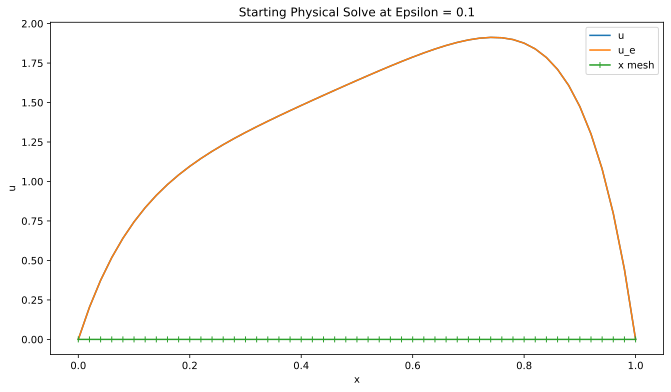



  0 SNES Function norm 1.683803766005e+00
  1 SNES Function norm 1.112192558246e+00
  2 SNES Function norm 6.873431335956e-01
  3 SNES Function norm 3.732733274169e-01
  4 SNES Function norm 1.772174475311e-01
  5 SNES Function norm 1.533723509860e-01
  6 SNES Function norm 1.762867617026e-01
  7 SNES Function norm 1.488028046780e-01
  8 SNES Function norm 1.029464536987e-01
  9 SNES Function norm 6.570856903045e-02
 10 SNES Function norm 4.069101235888e-02
 11 SNES Function norm 2.490315544979e-02
 12 SNES Function norm 1.517109369724e-02
 13 SNES Function norm 9.222862163513e-03
 14 SNES Function norm 5.594705393004e-03
 15 SNES Function norm 3.381811397593e-03
 16 SNES Function norm 2.033716172403e-03
 17 SNES Function norm 1.215963899309e-03
 18 SNES Function norm 7.239171615312e-04
 19 SNES Function norm 4.312019047210e-04
 20 SNES Function norm 2.592512033478e-04
 21 SNES Function norm 1.591755597303e-04
 22 SNES Function norm 1.008176016012e-04
 23 SNES Function norm 6.6042982

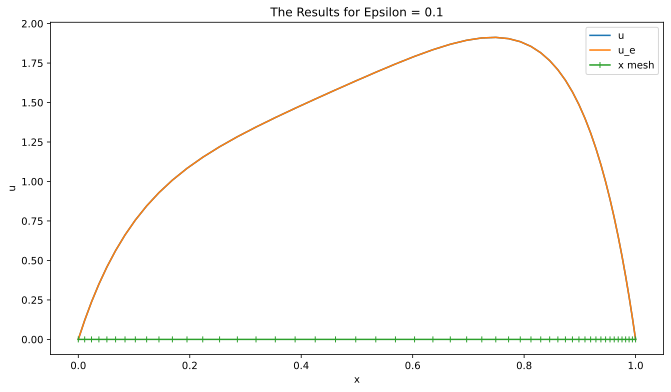



Continuation checks
norm(x) =  0.6721124337070941
norm(u) =  1.3211492160175686



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.07500000000000001
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.6721124337070941
norm(u) =  1.3211492160175686



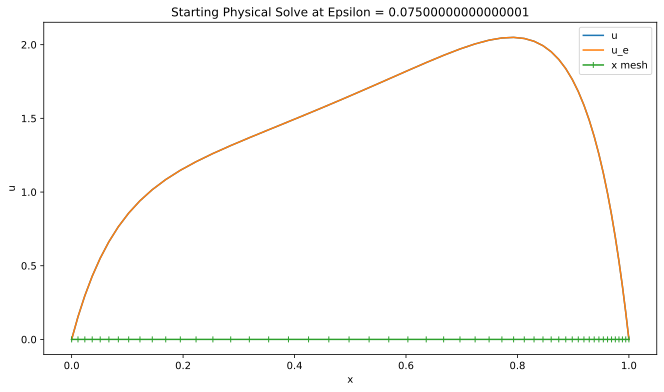



  0 SNES Function norm 2.819590011697e-01
  1 SNES Function norm 1.425267696778e-01
  2 SNES Function norm 8.366312555045e-02
  3 SNES Function norm 6.043910753092e-02
  4 SNES Function norm 4.569979447720e-02
  5 SNES Function norm 3.365812629173e-02
  6 SNES Function norm 2.424430689084e-02
  7 SNES Function norm 1.728495670132e-02
  8 SNES Function norm 1.230458617249e-02
  9 SNES Function norm 8.769161992510e-03
 10 SNES Function norm 6.222049328117e-03
 11 SNES Function norm 4.384987942366e-03
 12 SNES Function norm 3.071747724748e-03
 13 SNES Function norm 2.146391785782e-03
 14 SNES Function norm 1.510875302277e-03
 15 SNES Function norm 1.089870309200e-03
 16 SNES Function norm 8.242325490405e-04
 17 SNES Function norm 6.662750877520e-04
 18 SNES Function norm 5.775888600041e-04
 19 SNES Function norm 5.296290415261e-04
 20 SNES Function norm 5.039368509249e-04
 21 SNES Function norm 4.900181632051e-04
 22 SNES Function norm 4.823412256870e-04
 23 SNES Function norm 4.7804642

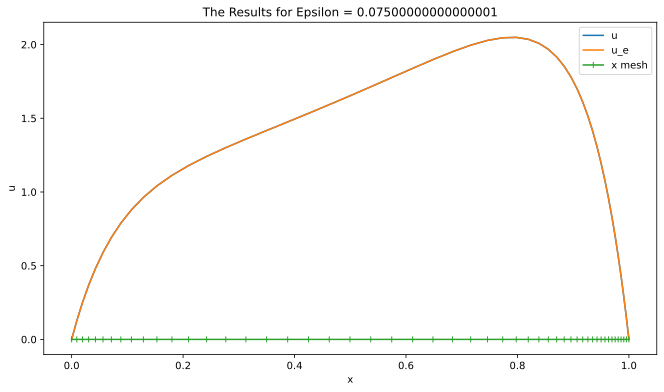



Continuation checks
norm(x) =  0.6819787126722906
norm(u) =  1.39059167950248



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.05625000000000001
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.6819787126722906
norm(u) =  1.39059167950248



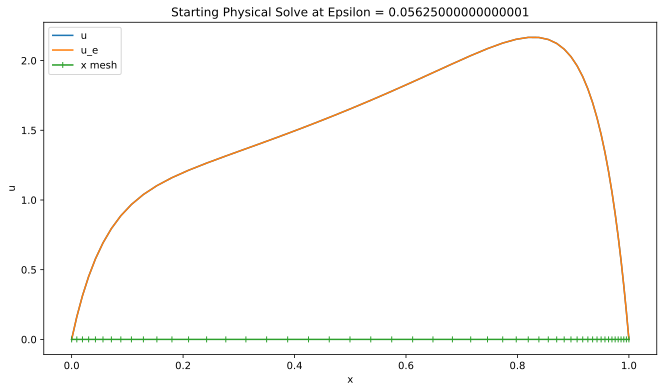



  0 SNES Function norm 3.449366116222e-01
  1 SNES Function norm 1.835104595350e-01
  2 SNES Function norm 1.119381542236e-01
  3 SNES Function norm 8.261472596003e-02
  4 SNES Function norm 6.468802585327e-02
  5 SNES Function norm 5.013458054104e-02
  6 SNES Function norm 3.826809972860e-02
  7 SNES Function norm 2.881841128710e-02
  8 SNES Function norm 2.139538494312e-02
  9 SNES Function norm 1.563952637325e-02
 10 SNES Function norm 1.123212030715e-02
 11 SNES Function norm 7.907232639447e-03
 12 SNES Function norm 5.453958271384e-03
 13 SNES Function norm 3.694313117451e-03
 14 SNES Function norm 2.467695214537e-03
 15 SNES Function norm 1.643145151864e-03
 16 SNES Function norm 1.118336153626e-03
 17 SNES Function norm 8.137351592147e-04
 18 SNES Function norm 6.610787730558e-04
 19 SNES Function norm 5.977278283893e-04
 20 SNES Function norm 5.763354313531e-04
 21 SNES Function norm 5.709058878119e-04
 22 SNES Function norm 5.704574015718e-04
 23 SNES Function norm 5.7113713

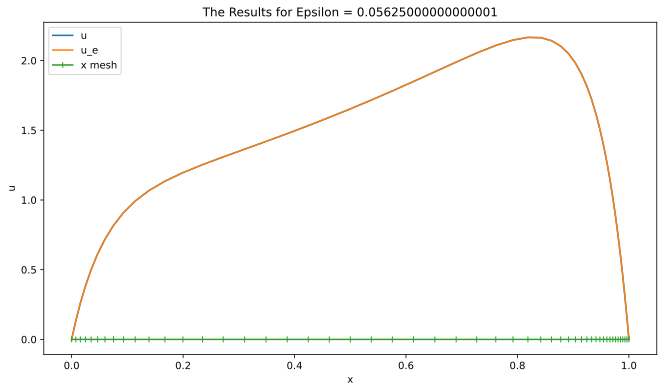



Continuation checks
norm(x) =  0.6898120709425909
norm(u) =  1.4448171745538827



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0421875
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.6898120709425909
norm(u) =  1.4448171745538827



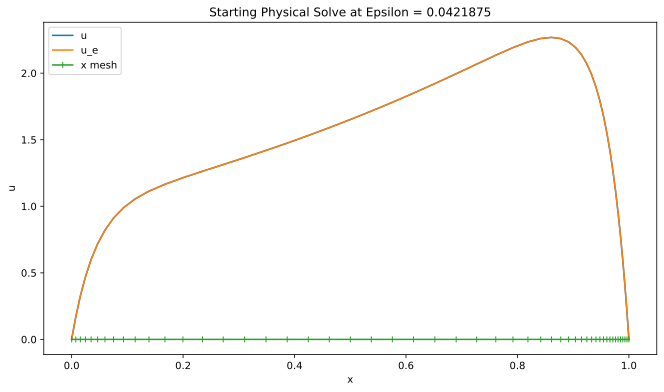



  0 SNES Function norm 4.043865041641e-01
  1 SNES Function norm 2.279133693108e-01
  2 SNES Function norm 1.462869809941e-01
  3 SNES Function norm 1.122329215545e-01
  4 SNES Function norm 9.249458360880e-02
  5 SNES Function norm 7.652694410363e-02
  6 SNES Function norm 6.251745459146e-02
  7 SNES Function norm 4.993948239465e-02
  8 SNES Function norm 3.883642456991e-02
  9 SNES Function norm 2.942522861952e-02
 10 SNES Function norm 2.177126469102e-02
 11 SNES Function norm 1.575686534832e-02
 12 SNES Function norm 1.119441447821e-02
 13 SNES Function norm 7.853517763132e-03
 14 SNES Function norm 5.458803879517e-03
 15 SNES Function norm 3.819548359083e-03
 16 SNES Function norm 2.751487042948e-03
 17 SNES Function norm 2.094388611484e-03
 18 SNES Function norm 1.718673285518e-03
 19 SNES Function norm 1.520866724050e-03
 20 SNES Function norm 1.424883399233e-03
 21 SNES Function norm 1.382034520862e-03
 22 SNES Function norm 1.364933598255e-03
 23 SNES Function norm 1.3594581

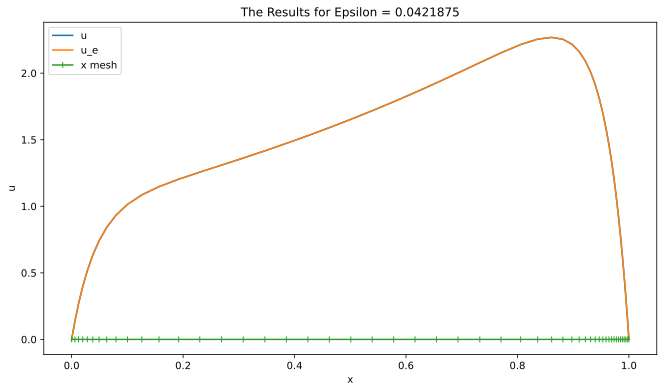



Continuation checks
norm(x) =  0.696439253285244
norm(u) =  1.4866989511572766



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.031640625000000006
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.696439253285244
norm(u) =  1.4866989511572766



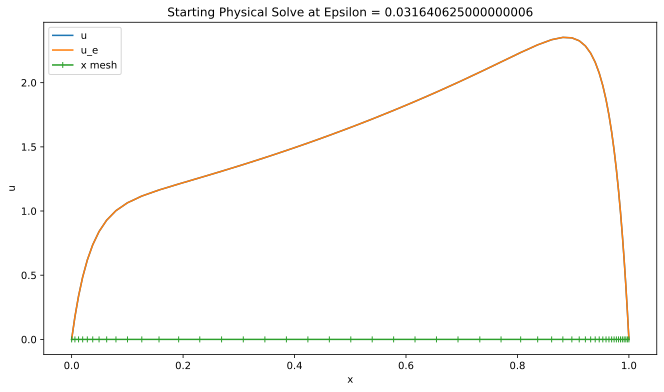



  0 SNES Function norm 4.701676770584e-01
  1 SNES Function norm 2.839002948210e-01
  2 SNES Function norm 1.900922566908e-01
  3 SNES Function norm 1.496088654271e-01
  4 SNES Function norm 1.291580971375e-01
  5 SNES Function norm 1.137173114170e-01
  6 SNES Function norm 9.876999109074e-02
  7 SNES Function norm 8.335895603798e-02
  8 SNES Function norm 6.788003615504e-02
  9 SNES Function norm 5.330129481724e-02
 10 SNES Function norm 4.046641823594e-02
 11 SNES Function norm 2.973655498397e-02
 12 SNES Function norm 2.119021514274e-02
 13 SNES Function norm 1.468085799712e-02
 14 SNES Function norm 9.916669614785e-03
 15 SNES Function norm 6.574758113419e-03
 16 SNES Function norm 4.312308731884e-03
 17 SNES Function norm 2.823487907259e-03
 18 SNES Function norm 1.860090397287e-03
 19 SNES Function norm 1.237736618531e-03
 20 SNES Function norm 8.312189635935e-04
 21 SNES Function norm 5.623000705506e-04
 22 SNES Function norm 3.846757452060e-04
 23 SNES Function norm 2.7077141

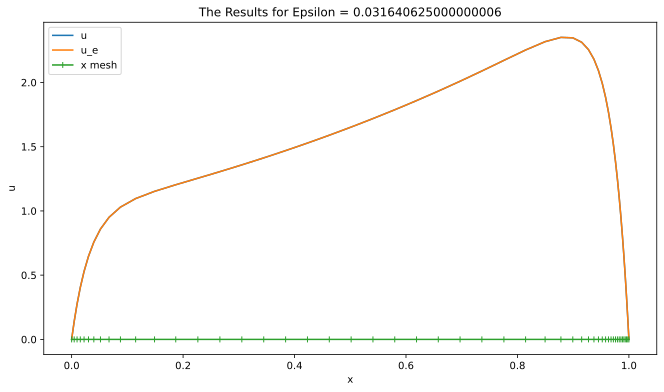



Continuation checks
norm(x) =  0.7019305686455416
norm(u) =  1.5190638679930473



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.023730468750000004
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7019305686455416
norm(u) =  1.5190638679930473



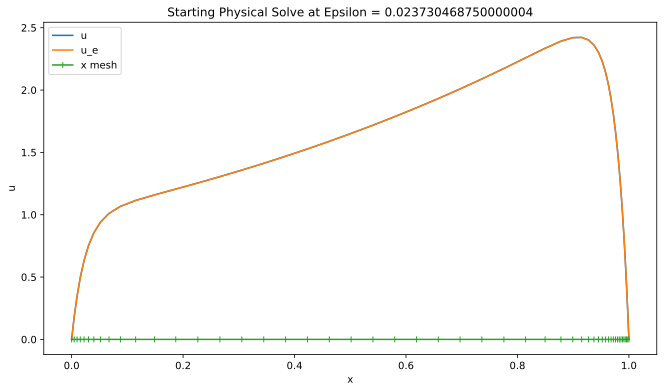



  0 SNES Function norm 5.454939314953e-01
  1 SNES Function norm 3.556463547461e-01
  2 SNES Function norm 2.470280337391e-01
  3 SNES Function norm 1.961605777020e-01
  4 SNES Function norm 1.752672242852e-01
  5 SNES Function norm 1.635338563595e-01
  6 SNES Function norm 1.509359781425e-01
  7 SNES Function norm 1.345540422653e-01
  8 SNES Function norm 1.150247082655e-01
  9 SNES Function norm 9.403705982805e-02
 10 SNES Function norm 7.373361245589e-02
 11 SNES Function norm 5.568275136360e-02
 12 SNES Function norm 4.056543702341e-02
 13 SNES Function norm 2.857989664156e-02
 14 SNES Function norm 1.956839000286e-02
 15 SNES Function norm 1.312958160979e-02
 16 SNES Function norm 8.762993432376e-03
 17 SNES Function norm 5.924384087662e-03
 18 SNES Function norm 4.115517307368e-03
 19 SNES Function norm 2.943552929433e-03
 20 SNES Function norm 2.150674466655e-03
 21 SNES Function norm 1.597733145517e-03
 22 SNES Function norm 1.219426263045e-03
 23 SNES Function norm 9.8085863

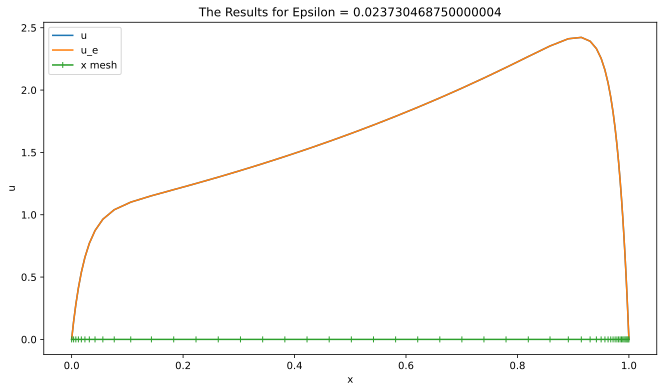



Continuation checks
norm(x) =  0.7063783905967465
norm(u) =  1.5440593565210214



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0177978515625
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7063783905967465
norm(u) =  1.5440593565210214



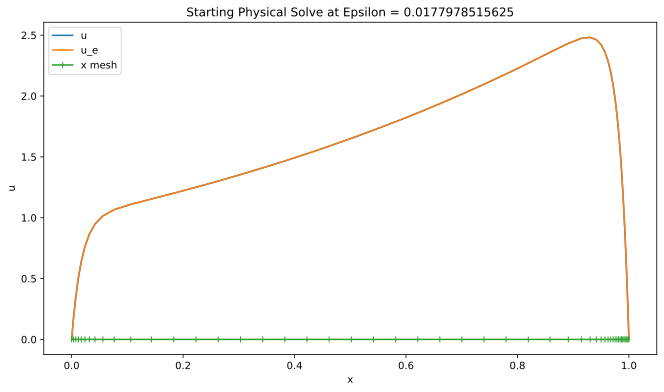



  0 SNES Function norm 6.308085760407e-01
  1 SNES Function norm 4.451332042627e-01
  2 SNES Function norm 3.194087116793e-01
  3 SNES Function norm 2.527848597893e-01
  4 SNES Function norm 2.308981349846e-01
  5 SNES Function norm 2.268244242513e-01
  6 SNES Function norm 2.211510855599e-01
  7 SNES Function norm 2.063865785435e-01
  8 SNES Function norm 1.841214269776e-01
  9 SNES Function norm 1.572454145979e-01
 10 SNES Function norm 1.285032564138e-01
 11 SNES Function norm 1.006337323979e-01
 12 SNES Function norm 7.568586097049e-02
 13 SNES Function norm 5.483286820500e-02
 14 SNES Function norm 3.842068341491e-02
 15 SNES Function norm 2.627944146052e-02
 16 SNES Function norm 1.786548450394e-02
 17 SNES Function norm 1.238736316375e-02
 18 SNES Function norm 8.938592056516e-03
 19 SNES Function norm 6.689924524061e-03
 20 SNES Function norm 5.073997007763e-03
 21 SNES Function norm 3.813911432531e-03
 22 SNES Function norm 2.821620580221e-03
 23 SNES Function norm 2.0913640

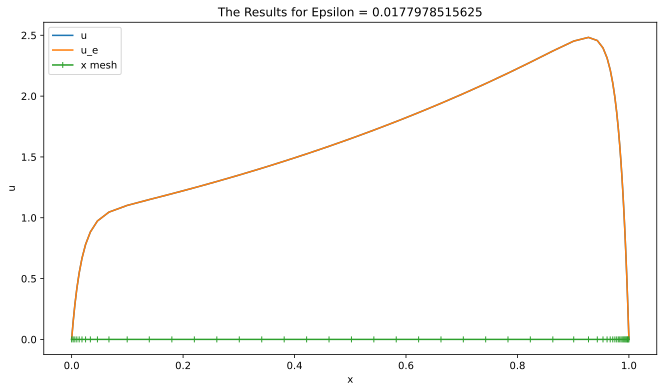



Continuation checks
norm(x) =  0.7099222497924103
norm(u) =  1.5633276374022789



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.013348388671875001
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7099222497924103
norm(u) =  1.5633276374022789



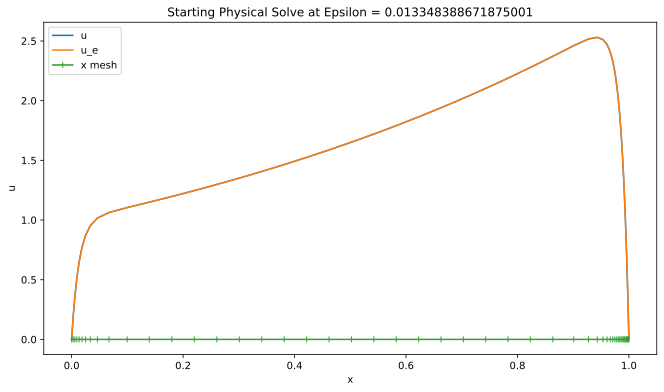



  0 SNES Function norm 7.255170203168e-01
  1 SNES Function norm 5.510339221010e-01
  2 SNES Function norm 4.083321519784e-01
  3 SNES Function norm 3.196295442448e-01
  4 SNES Function norm 2.923425388379e-01
  5 SNES Function norm 2.992661289910e-01
  6 SNES Function norm 3.083093317770e-01
  7 SNES Function norm 3.040909205563e-01
  8 SNES Function norm 2.843983468764e-01
  9 SNES Function norm 2.526285088203e-01
 10 SNES Function norm 2.133821915100e-01
 11 SNES Function norm 1.716284101657e-01
 12 SNES Function norm 1.316558069203e-01
 13 SNES Function norm 9.710097285949e-02
 14 SNES Function norm 6.902222705881e-02
 15 SNES Function norm 4.763761895418e-02
 16 SNES Function norm 3.254828733605e-02
 17 SNES Function norm 2.290800285389e-02
 18 SNES Function norm 1.724077227725e-02
 19 SNES Function norm 1.384952030362e-02
 20 SNES Function norm 1.142822907836e-02
 21 SNES Function norm 9.349737201096e-03
 22 SNES Function norm 7.457863975778e-03
 23 SNES Function norm 5.8066721

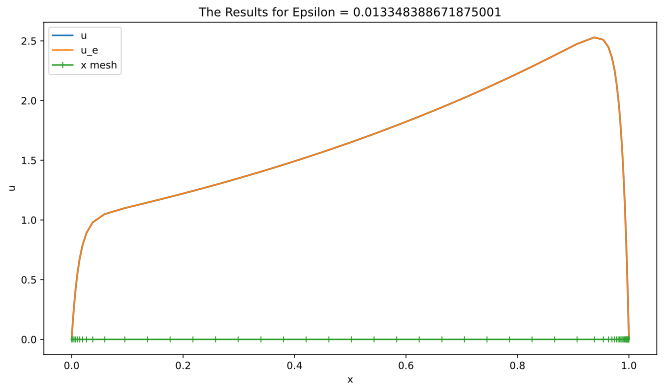



Continuation checks
norm(x) =  0.7126999677877418
norm(u) =  1.5781011467942272



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.01001129150390625
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7126999677877418
norm(u) =  1.5781011467942272



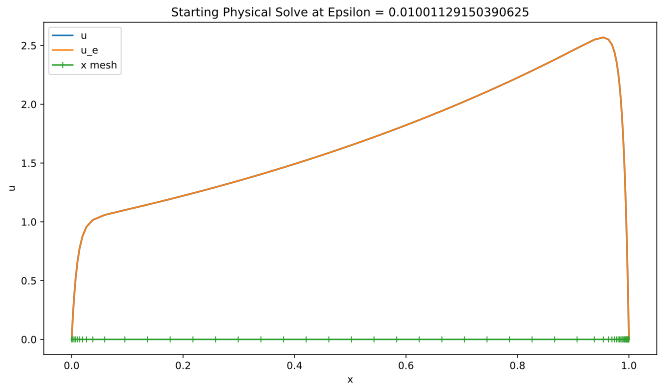



  0 SNES Function norm 8.319255559739e-01
  1 SNES Function norm 6.760206013277e-01
  2 SNES Function norm 5.183838999592e-01
  3 SNES Function norm 4.003165409426e-01
  4 SNES Function norm 3.573565247345e-01
  5 SNES Function norm 3.701423560587e-01
  6 SNES Function norm 3.960064060545e-01
  7 SNES Function norm 4.105690000819e-01
  8 SNES Function norm 4.050120268337e-01
  9 SNES Function norm 3.791228495503e-01
 10 SNES Function norm 3.372246381739e-01
 11 SNES Function norm 2.856376186942e-01
 12 SNES Function norm 2.302707108197e-01
 13 SNES Function norm 1.765407847224e-01
 14 SNES Function norm 1.286441470878e-01
 15 SNES Function norm 8.937180978920e-02
 16 SNES Function norm 5.998562323573e-02
 17 SNES Function norm 4.048789242880e-02
 18 SNES Function norm 2.943468371565e-02
 19 SNES Function norm 2.382376927637e-02
 20 SNES Function norm 2.040877854604e-02
 21 SNES Function norm 1.736092497860e-02
 22 SNES Function norm 1.420306930213e-02
 23 SNES Function norm 1.1067358

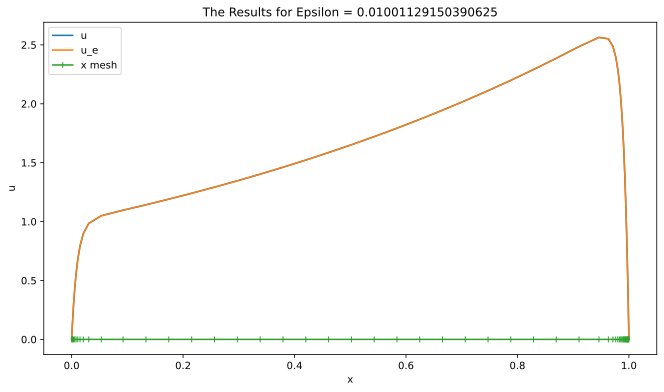



Continuation checks
norm(x) =  0.7148620810465622
norm(u) =  1.5894764969909936



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.007508468627929688
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7148620810465622
norm(u) =  1.5894764969909936



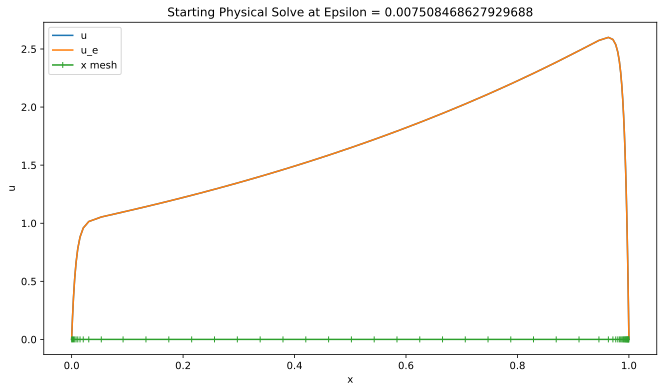



  0 SNES Function norm 9.435506859182e-01
  1 SNES Function norm 8.127130327919e-01
  2 SNES Function norm 6.365255198305e-01
  3 SNES Function norm 4.881721932598e-01
  4 SNES Function norm 4.341489736344e-01
  5 SNES Function norm 4.554962046367e-01
  6 SNES Function norm 4.915860815550e-01
  7 SNES Function norm 5.113243941601e-01
  8 SNES Function norm 5.101343188501e-01
  9 SNES Function norm 4.914426215286e-01
 10 SNES Function norm 4.563606792622e-01
 11 SNES Function norm 4.073521737422e-01
 12 SNES Function norm 3.483207436207e-01
 13 SNES Function norm 2.855400207681e-01
 14 SNES Function norm 2.233879702787e-01
 15 SNES Function norm 1.660034660470e-01
 16 SNES Function norm 1.172791174585e-01
 17 SNES Function norm 8.007817814047e-02
 18 SNES Function norm 5.580887364678e-02
 19 SNES Function norm 4.337095398356e-02
 20 SNES Function norm 3.818431000603e-02
 21 SNES Function norm 3.522399699612e-02
 22 SNES Function norm 3.197950043850e-02
 23 SNES Function norm 2.7977684

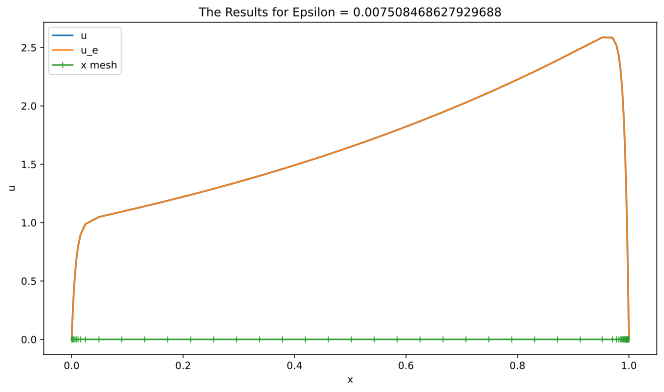



Continuation checks
norm(x) =  0.7165322165656965
norm(u) =  1.5981416075449784



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.005631351470947266
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7165322165656965
norm(u) =  1.5981416075449784



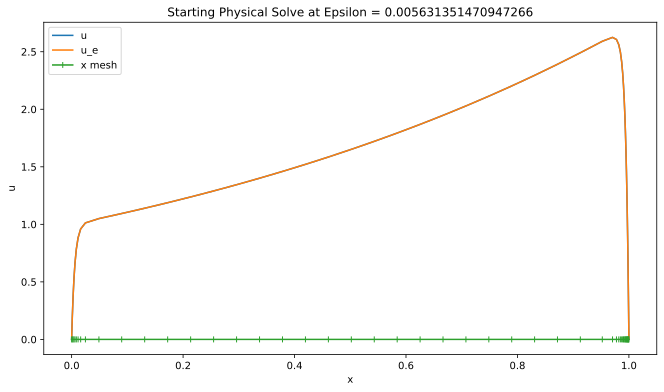



  0 SNES Function norm 1.065615228462e+00
  1 SNES Function norm 9.236712171978e-01
  2 SNES Function norm 7.309184903430e-01
  3 SNES Function norm 5.536035952011e-01
  4 SNES Function norm 4.801051485090e-01
  5 SNES Function norm 5.248067981956e-01
  6 SNES Function norm 6.009124581900e-01
  7 SNES Function norm 6.466763518085e-01
  8 SNES Function norm 6.482743743975e-01
  9 SNES Function norm 6.151943287739e-01
 10 SNES Function norm 5.614245758528e-01
 11 SNES Function norm 4.985631281634e-01
 12 SNES Function norm 4.364585955845e-01
 13 SNES Function norm 3.732134065463e-01
 14 SNES Function norm 3.091446316070e-01
 15 SNES Function norm 2.454302290000e-01
 16 SNES Function norm 1.848820650296e-01
 17 SNES Function norm 1.316996441869e-01
 18 SNES Function norm 8.952226142530e-02
 19 SNES Function norm 6.092524080155e-02
 20 SNES Function norm 4.612445128475e-02
 21 SNES Function norm 4.071866664509e-02
 22 SNES Function norm 3.820732403502e-02
 23 SNES Function norm 3.5038681

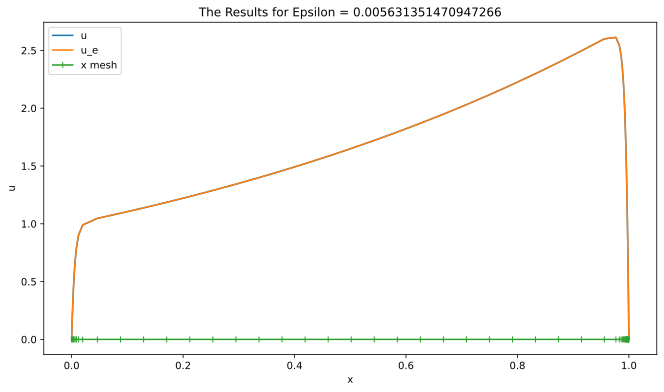



Continuation checks
norm(x) =  0.7178188186867102
norm(u) =  1.6048704321666138



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.004223513603210449
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7178188186867102
norm(u) =  1.6048704321666138



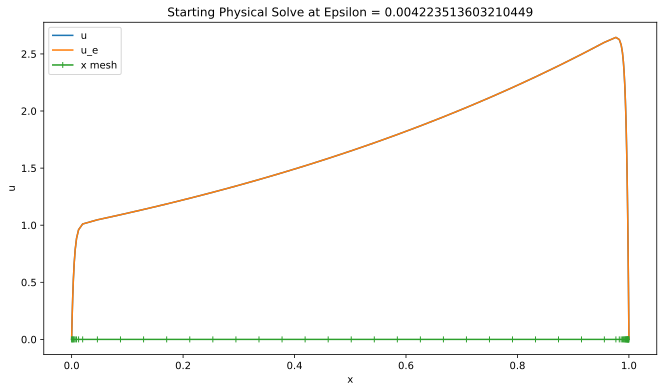



  0 SNES Function norm 1.114055820028e+00
  1 SNES Function norm 9.881964706541e-01
  2 SNES Function norm 8.164425850156e-01
  3 SNES Function norm 6.260755805988e-01
  4 SNES Function norm 5.131842300271e-01
  5 SNES Function norm 5.605107010291e-01
  6 SNES Function norm 6.921137610750e-01
  7 SNES Function norm 8.032488875678e-01
  8 SNES Function norm 8.486925521118e-01
  9 SNES Function norm 8.274184327356e-01
 10 SNES Function norm 7.608600399302e-01
 11 SNES Function norm 6.754792158306e-01
 12 SNES Function norm 5.860831587667e-01
 13 SNES Function norm 4.967271223101e-01
 14 SNES Function norm 4.074051643172e-01
 15 SNES Function norm 3.299658798688e-01
 16 SNES Function norm 2.601434511965e-01
 17 SNES Function norm 1.955894133669e-01
 18 SNES Function norm 1.396240594157e-01
 19 SNES Function norm 9.577636920647e-02
 20 SNES Function norm 6.681560143286e-02
 21 SNES Function norm 5.266430022825e-02
 22 SNES Function norm 4.811338785532e-02
 23 SNES Function norm 4.6605670

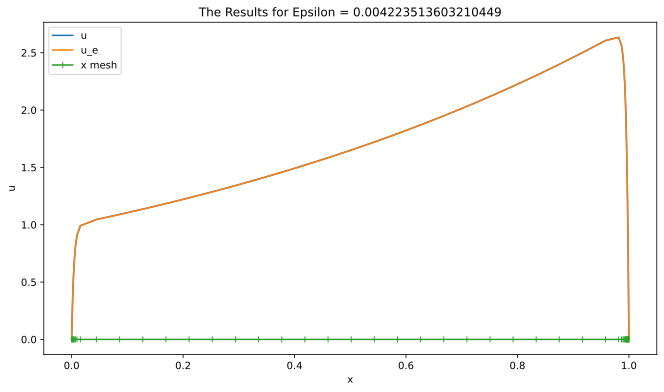



Continuation checks
norm(x) =  0.7188114739932556
norm(u) =  1.6098735757884413



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0031676352024078373
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7188114739932556
norm(u) =  1.6098735757884413



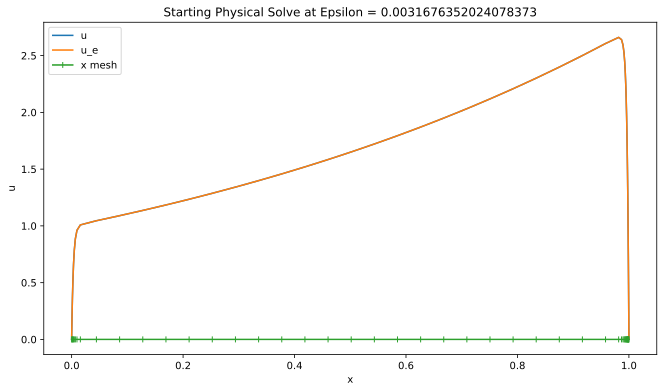



  0 SNES Function norm 1.112124672390e+00
  1 SNES Function norm 1.065739749422e+00
  2 SNES Function norm 9.534542906071e-01
  3 SNES Function norm 7.666992856685e-01
  4 SNES Function norm 6.044759495125e-01
  5 SNES Function norm 5.913815184567e-01
  6 SNES Function norm 7.274821131724e-01
  7 SNES Function norm 9.020842612971e-01
  8 SNES Function norm 1.031551417370e+00
  9 SNES Function norm 1.076244538878e+00
 10 SNES Function norm 1.033425782311e+00
 11 SNES Function norm 9.256125019734e-01
 12 SNES Function norm 7.854423346041e-01
 13 SNES Function norm 6.432914344031e-01
 14 SNES Function norm 5.203069300112e-01
 15 SNES Function norm 4.253600586043e-01
 16 SNES Function norm 3.561853413706e-01
 17 SNES Function norm 3.048811874005e-01
 18 SNES Function norm 2.641297862156e-01
 19 SNES Function norm 2.275863837617e-01
 20 SNES Function norm 1.937500486386e-01
 21 SNES Function norm 1.651069356004e-01
 22 SNES Function norm 1.428711791668e-01
 23 SNES Function norm 1.2721719

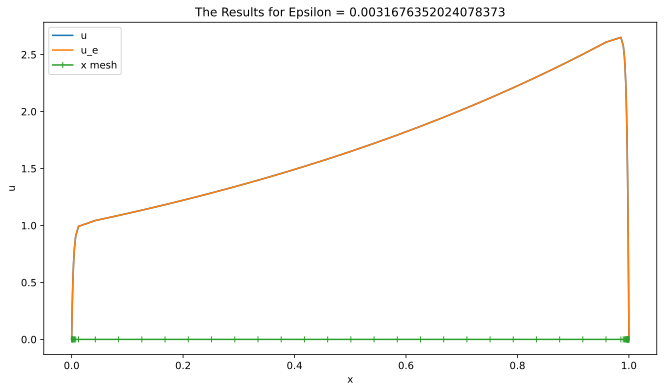



Continuation checks
norm(x) =  0.719397514383194
norm(u) =  1.6131880421437654



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.002375726401805878
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.719397514383194
norm(u) =  1.6131880421437654



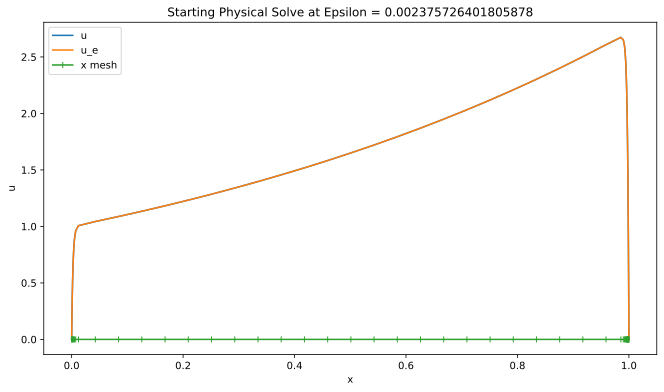



  0 SNES Function norm 1.132873991898e+00
  1 SNES Function norm 1.179094356906e+00
  2 SNES Function norm 1.123037532974e+00
  3 SNES Function norm 9.353111662201e-01
  4 SNES Function norm 6.788347641312e-01
  5 SNES Function norm 6.143438767599e-01
  6 SNES Function norm 7.758080963972e-01
  7 SNES Function norm 9.627138196983e-01
  8 SNES Function norm 1.119419069594e+00
  9 SNES Function norm 1.265454782154e+00
 10 SNES Function norm 1.319987778490e+00
 11 SNES Function norm 1.273422523402e+00
 12 SNES Function norm 1.142893583364e+00
 13 SNES Function norm 9.610801103874e-01
 14 SNES Function norm 7.623847495457e-01
 15 SNES Function norm 5.769701599993e-01
 16 SNES Function norm 4.235444574180e-01
 17 SNES Function norm 3.080217538433e-01
 18 SNES Function norm 2.260363100472e-01
 19 SNES Function norm 1.688000881917e-01
 20 SNES Function norm 1.289649367599e-01
 21 SNES Function norm 1.025857500719e-01
 22 SNES Function norm 8.671646349470e-02
 23 SNES Function norm 7.7426917

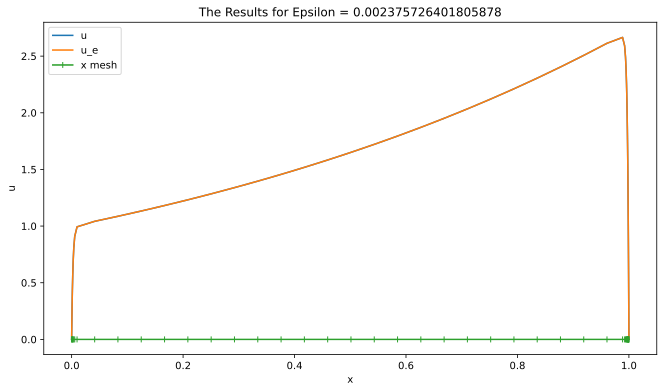



Continuation checks
norm(x) =  0.7200985747619381
norm(u) =  1.6169367563239494



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0017817948013544084
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7200985747619381
norm(u) =  1.6169367563239494



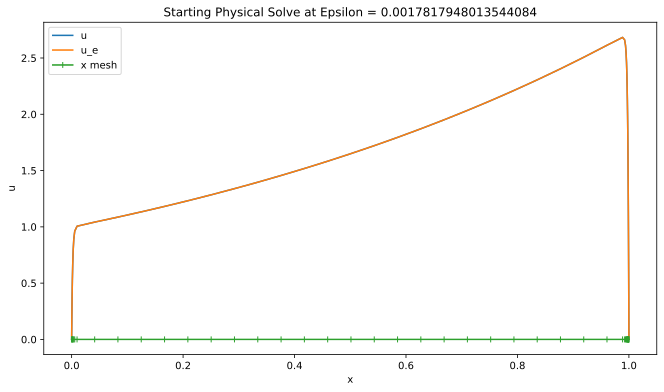



  0 SNES Function norm 1.177984496641e+00
  1 SNES Function norm 1.293150063926e+00
  2 SNES Function norm 1.293379958761e+00
  3 SNES Function norm 1.067980366903e+00
  4 SNES Function norm 7.526884130716e-01
  5 SNES Function norm 6.355237344636e-01
  6 SNES Function norm 7.883873058057e-01
  7 SNES Function norm 1.051441658873e+00
  8 SNES Function norm 1.294686219216e+00
  9 SNES Function norm 1.406492106882e+00
 10 SNES Function norm 1.454025348390e+00
 11 SNES Function norm 1.504603376794e+00
 12 SNES Function norm 1.471739551503e+00
 13 SNES Function norm 1.342555979190e+00
 14 SNES Function norm 1.146846448910e+00
 15 SNES Function norm 9.211228615922e-01
 16 SNES Function norm 6.985557485164e-01
 17 SNES Function norm 5.031813795722e-01
 18 SNES Function norm 3.475538538927e-01
 19 SNES Function norm 2.336581458632e-01
 20 SNES Function norm 1.567290054327e-01
 21 SNES Function norm 1.108550482011e-01
 22 SNES Function norm 9.163384301245e-02
 23 SNES Function norm 9.1289901

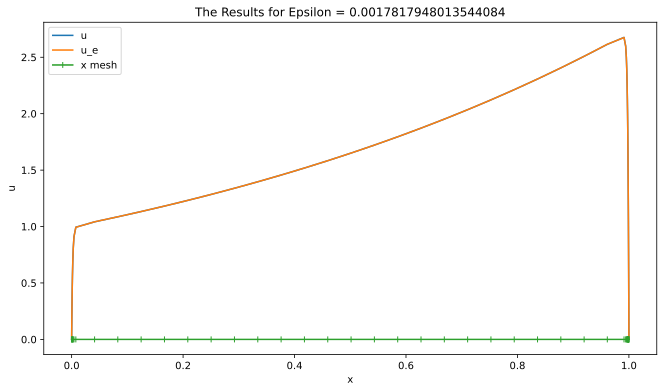



Continuation checks
norm(x) =  0.7205861318513482
norm(u) =  1.618866986421726



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0013363461010158064
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7205861318513482
norm(u) =  1.618866986421726



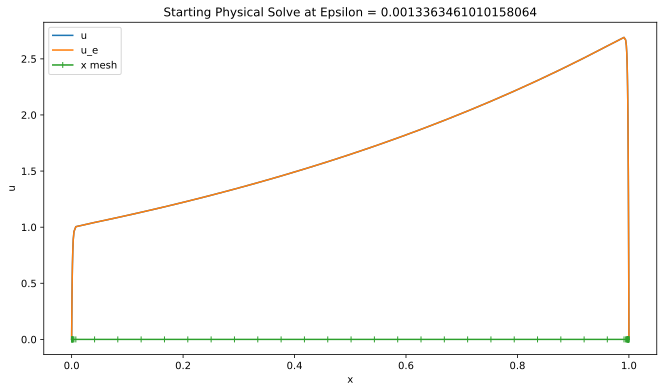



  0 SNES Function norm 1.211333331138e+00
  1 SNES Function norm 1.402331440554e+00
  2 SNES Function norm 1.455919920313e+00
  3 SNES Function norm 1.228198384015e+00
  4 SNES Function norm 9.172086865583e-01
  5 SNES Function norm 7.211727069887e-01
  6 SNES Function norm 7.378942019608e-01
  7 SNES Function norm 9.589299531815e-01
  8 SNES Function norm 1.245428012624e+00
  9 SNES Function norm 1.483115201863e+00
 10 SNES Function norm 1.626272444467e+00
 11 SNES Function norm 1.582428874685e+00
 12 SNES Function norm 1.563786072526e+00
 13 SNES Function norm 1.550800323329e+00
 14 SNES Function norm 1.438039198687e+00
 15 SNES Function norm 1.252560141592e+00
 16 SNES Function norm 1.028162637693e+00
 17 SNES Function norm 7.973801295099e-01
 18 SNES Function norm 5.856426959777e-01
 19 SNES Function norm 4.086332202592e-01
 20 SNES Function norm 2.723477778633e-01
 21 SNES Function norm 1.753332150311e-01
 22 SNES Function norm 1.125654869995e-01
 23 SNES Function norm 7.9316068

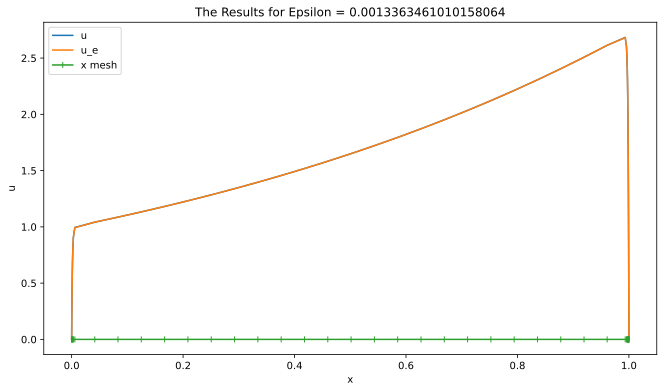



Continuation checks
norm(x) =  0.7208589740394776
norm(u) =  1.619350648779667



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0010022595757618548
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7208589740394776
norm(u) =  1.619350648779667



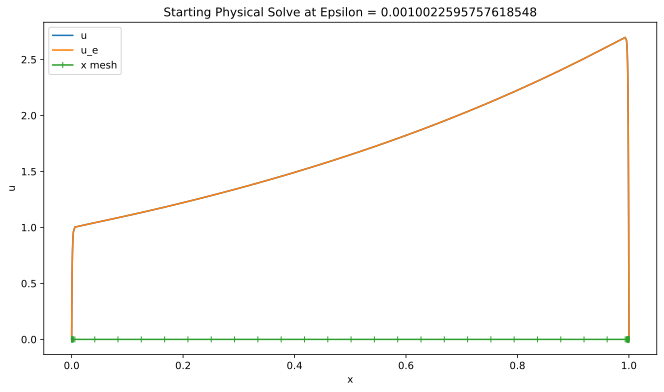



  0 SNES Function norm 1.254628074983e+00
  1 SNES Function norm 1.501483863848e+00
  2 SNES Function norm 1.597946086675e+00
  3 SNES Function norm 1.403193622163e+00
  4 SNES Function norm 1.127848707819e+00
  5 SNES Function norm 8.865113292352e-01
  6 SNES Function norm 7.604383588580e-01
  7 SNES Function norm 8.357840293995e-01
  8 SNES Function norm 1.081700533190e+00
  9 SNES Function norm 1.391072498615e+00
 10 SNES Function norm 1.641260539739e+00
 11 SNES Function norm 1.773003461170e+00
 12 SNES Function norm 1.795638732846e+00
 13 SNES Function norm 1.658997605225e+00
 14 SNES Function norm 1.585467597906e+00
 15 SNES Function norm 1.505768964430e+00
 16 SNES Function norm 1.346692985949e+00
 17 SNES Function norm 1.139033307990e+00
 18 SNES Function norm 9.134245550436e-01
 19 SNES Function norm 6.958324697648e-01
 20 SNES Function norm 5.043756415589e-01
 21 SNES Function norm 3.484864825294e-01
 22 SNES Function norm 2.300133737818e-01
 23 SNES Function norm 1.4572206

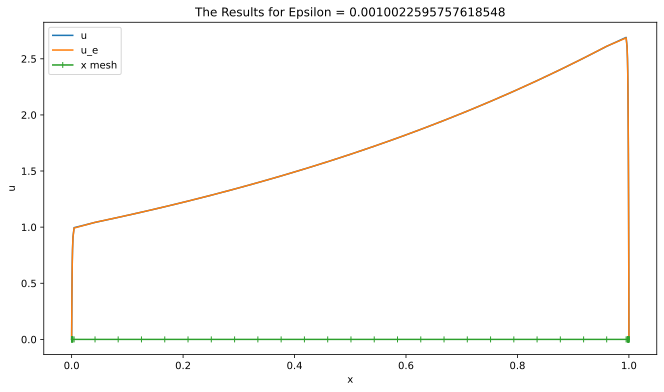



Continuation checks
norm(x) =  0.7209412283985022
norm(u) =  1.6188945633841094



In [7]:
# SET EPSILONS
epsilon = 0.1
eps_final = 1e-3
eps_change = 3/4
results = []



# M PARAMETERS (m=0 IS L2)
p = 2
q = 2
m = 0
exp_M = Constant( (2*q) / (1 + q*(2-m)) )
alpha_power = -3/4
alpha_scale = 5


# INITIAL GUESSES
x = Function(V_mesh).interpolate(SpatialCoordinate(xi_mesh)[0])
u = Function(V_phys).interpolate(x+1/2)
x_save = Function(V_mesh)
u_save = Function(V_phys)
results = []


# EPSILON CONTINUATION
##########################################################


while epsilon >= eps_final:


    print()
    print()
    print('-_'*100)
    print('EPSILON = ', epsilon)
    print('-_'*100)
    print()
    print()


    # continuation checks
    print('Epsilon continuation checks')
    print("norm(x) = ", norm(x))
    print("norm(u) = ", norm(u))
    print()



    # STARTING PHYSICAL SOLVE AT NEW EPSILON ON OLD MESH

    # Test and Trial Functions
    u_new = TrialFunction(V_phys)
    v = TestFunction(V_phys)

    # Jacobian of x
    Jx = x.dx(0) #dx/dxi

    # Set the bilinear and linear forms of the weak form
    u_deriv = (1/Jx) * u_new.dx(0) # transform to du/dx
    v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
    a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u_new, v)) * Jx * dx # transform dxi to dx
    L = ( exp(x) ) * v * Jx * dx #transform dxi to dx

    # Set the BC's
    bcs = [DirichletBC(V_phys, Constant(0), 1), DirichletBC(V_phys, Constant(0), 2)]

    # Solve
    try:
      u_new = Function(V_phys).interpolate(u)
      solve( a==L, u_new, bcs = bcs, solver_parameters = lu_params)
    except Exception as e:
      print('The physical solve failed due to the following message:')
      print(e)
      print()

    # Update u
    u.dat.data[:] = u_new.dat.data[:]


    # exact u
    top = (1 - exp(1 - 1/epsilon))*exp(-x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x-1)/epsilon)
    bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
    sub = exp(x)/(epsilon**2 - 1)
    u_e = top/bottom - sub

    # plot
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(u).dat.data[perm_x], label = 'u')
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(u_e).dat.data[perm_x], label = 'u_e')
    plt.plot(x.dat.data[perm_x], [0 for i in range(len(x.dat.data[perm_x]))], marker = '|', label = 'x mesh')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('Starting Physical Solve at Epsilon = ' + str(epsilon))
    plt.legend()
    plt.show()
    print()
    print()



    # MP ITERATION
    ################################################


    # SETUP
    W = V_mesh * V_phys * V_mesh
    xux = Function(W)
    yvy = TestFunction(W)

    # set our initial guesses
    xux.sub(0).interpolate(x)
    xux.sub(1).interpolate(u)
    xux.sub(2).interpolate(x)


    # Retrieve our functions
    x, u, x_old = split(xux)
    y,v, y_old = split(yvy)


    # MESH DENSITY FUNCTION BASED ON XOLD

    # x_old jacobian
    jacobx = x_old.dx(0) #dx/dxi

    # compute the derivatives of our u
    u_pr_lin = u.dx(0)
    u_prpr_lin = u_pr_lin.dx(0)
    x_prpr_lin = jacobx.dx(0)
    du_dx_lin = (1/jacobx) * u_pr_lin
    du2_dx2_lin = ( u_prpr_lin -  du_dx_lin * x_prpr_lin) * (( 1/jacobx )**2)

    # compute the Hessian M
    alpha = alpha_scale * epsilon ** (alpha_power)
    inside_bit_lin = 1 + (1/alpha) * abs(du2_dx2_lin)
    M_lin = inside_bit_lin ** (exp_M)


    # MESH PROBLEM

    # Jacobian
    Jm = x.dx(0)
    # y' where y is test for x
    y_pr_term = y.dx(0)
    # Residual
    F_mesh = (M_lin * Jm * y_pr_term)*dx


    # PHYSICAL SOLVE BASED ON SOLUTION FOR X


    # Physical PDE
    u_deriv = (1/Jm) * u.dx(0) # transform to du/dx
    v_deriv = (1/Jm) * v.dx(0) # transform to dv/dx
    a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jm * dx # transform dxi to dx
    L = ( exp(x) ) * v * Jm * dx #transform dxi to dx
    F_phys = a - L





    # THE TOTAL FORM

    F = F_mesh + F_phys + (x-x_old)*y_old*dx

    # bc's
    bcx0 = DirichletBC(W.sub(0), Constant(0), 1)
    bcx1 = DirichletBC(W.sub(0), Constant(1), 2)
    bcu0 = DirichletBC(W.sub(1), Constant(0), 1)
    bcu1 = DirichletBC(W.sub(1), Constant(0), 2)
    bcs = [bcx0, bcx1, bcu0, bcu1]


    # SOLVE

    try:
      NLVP = NonlinearVariationalProblem(F, xux, bcs=bcs)
      NLVS = NonlinearVariationalSolver(NLVP, solver_parameters=FS_params)
      NLVS.solve()
    except Exception as e:
      print()
      print()
      print('Solver failed because of the following message:')
      print(e)
      print()


    # L2 AND ENERGY NORM FOR RESULT OF CURRENT EPSILON


    print()
    print('_'*100)
    print('RESULTS')
    print('_'*100)
    print()

    # Pull our results
    x, u, x_old = xux.subfunctions



    print("ERRORS:")

    # Exact Solution
    top = (1 - exp(1 - 1/epsilon))*exp(-x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x-1)/epsilon)
    bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
    sub = exp(x)/(epsilon**2 - 1)
    u_e = top/bottom - sub

    # L^2 error
    Jx = x.dx(0)
    error_val = (u - u_e)
    L2_error = norm(error_val * (sqrt(abs(Jx))))
    print("L2 error is", L2_error)

    # Energy norm error
    # (\eps^2 || u' ||_0^2 + || u ||_0^2 ) ^{1/2}
    u_approx_pr = (1/Jx) * u.dx(0)
    u_exact_pr = (1/Jx) * u_e.dx(0)
    u_pr_error = (u_approx_pr - u_exact_pr)
    L2_pr = norm(u_pr_error * (sqrt(abs(Jx))))
    energy_error =  float(sqrt( (epsilon**2) * (L2_pr**2) + (L2_error**2) ))
    print("Energy norm error is", energy_error)
    print()



    # SAVE AND PLOT THE RESULTS FOR THE CURRENT EPSILON

    # save
    u_save.dat.data[:] = u.dat.data[:]
    x_save.dat.data[:] = x.dat.data[:]
    results.append([epsilon, L2_error, energy_error, u_save, x_save])

    print('PLOTS:')

    # plot
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(u).dat.data[perm_x], label = 'u')
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(u_e).dat.data[perm_x], label = 'u_e')
    plt.plot(x.dat.data[perm_x], [0 for i in range(len(x.dat.data[perm_x]))], marker = '|', label = 'x mesh')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('The Results for Epsilon = ' + str(epsilon))
    plt.legend()
    plt.show()
    print()
    print()


    print('Continuation checks')
    print("norm(x) = ", norm(x))
    print("norm(u) = ", norm(u))
    print()


    # UPDATE EPSILON
    epsilon = epsilon * eps_change


